In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').resolve().parents[0]))

In [2]:
from pprint import pprint
from collections import Counter

import numpy as np
import pandas as pd
import sklearn
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from xgboost import XGBClassifier, plot_importance

from src import timer
from src.data import FeatherReadWriter, JDataTrainTestReadWriter
from src.models import monkey_patch
from src.models.metrics import get_jdata_scoring, jdata_fscorer

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot

pd.set_option('display.max_columns', 10000)
monkey_patch.run()

Patched!


## choose an appropriate sampler and sampling ratio by the submission

In [9]:
def get_X_y(dataset):
    X = dataset.drop(columns=["user_id", "label"]).fillna(-1).values
    y = dataset.label.values
    return X, y


def sampler(name, ratio, random_state=0, return_indices=True, **kwargs):
    if name == "rus":
        sampler = RandomUnderSampler(
            ratio=ratio,
            return_indices=return_indices,
            random_state=random_state,
            **kwargs,
        )
    elif name == "nm":
        sampler = NearMiss(
            ratio=ratio,
            return_indices=return_indices,
            random_state=random_state,
            **kwargs,
        )
    elif name == "enn":
        sampler = EditedNearestNeighbours(
            return_indices=return_indices, random_state=random_state, **kwargs
        )
    elif name == "renn":
        sampler = RepeatedEditedNearestNeighbours(
            return_indices=return_indices, random_state=random_state, **kwargs
        )
    elif name == "allknn":
        sampler = AllKNN(
            return_indices=return_indices, random_state=random_state, **kwargs
        )
    elif name == "tl":
        sampler = TomekLinks(
            return_indices=return_indices, random_state=random_state, **kwargs
        )
    else:
        raise ValueError
    return sampler


def merge_scoring_metrics(scores, scorer):
    df = pd.DataFrame(scores)
    custom_metrics = scorer.get(filter=None)
    for metric, scores in custom_metrics.items():
        df["test_{0}".format(metric)] = scores[::2]
        df["train_{0}".format(metric)] = scores[1::2]
    return df


def score_whole_dataset(clf, dataset, pre_train=True):
    if not ("label" in dataset):
        raise ValueError("dataset must include the label column")
    X, y = get_X_y(dataset)
    if not pre_train:
        clf.fit(X, y)
    scoring, scorer = get_jdata_scoring(dataset)
    scoring["custom_index"](clf, X, y, np.arange(X.shape[0]))

    metrics = {}
    for k, v in scorer.get(filter=None).items():
        metrics["test_{}".format(k)] = v

    return pd.DataFrame(metrics)

In [10]:
# load training dataset
frw = FeatherReadWriter()
train = frw.read(dir="processed", name=frw.extend_name("all_merged_1.0"), nthreads=4)
label = frw.read(
    dir="processed", name=frw.extend_name("all_merged_1.0.label"), nthreads=4
)
train[label.columns] = label
X, y = get_X_y(train)

# load online dataset for submission
online_train = frw.read(dir="processed", name=frw.extend_name("all_merged_online"), nthreads=4)
online_label = frw.read(
    dir="processed", name=frw.extend_name("all_merged_online.label"), nthreads=4
)
online_train[online_label.columns] = online_label

In [ ]:
sampling_paras = [
    ("rus", 0.1),
    ("rus", 0.01),
    ("rus", 0.001),
    ("nm", 0.1),
    ("nm", 0.01),
    ("nm", 0.001),
    ("tl", None),
    ("enn", None),
    ("renn", None),
    ("allknn", None),
]

fpath = str(PROJECT_DIR.joinpath("reports/metrics_by_samplers.csv"))
whole_dataset_metrics = pd.DataFrame()

for method, ratio in sampling_paras:
    with timer(f"method: {method}, ratio: {ratio}"):
        sampler_setting = {"name": method, "ratio": ratio, "n_jobs": 4}
        s = sampler(**sampler_setting)
        res_X, res_y, indices = s.fit_sample(X, y)
    print("Distribution of class labels after resampling {}".format(Counter(res_y)))

    clf = XGBClassifier(nthread=-1)
    with timer("start training"):
        clf.fit(res_X, res_y, verbose=3)

    score_df = score_whole_dataset(clf, online_train)
    score_df = score_df.set_index([["{0}-{1}".format(method, ratio)]])
    whole_dataset_metrics = pd.concat([whole_dataset_metrics, score_df])
    whole_dataset_metrics.to_csv(fpath)
    frw.write(
        pd.DataFrame({"index": indices}),
        "processed",
        frw.extend_name(f"all_merged_1.0_{method}_{ratio}_indices"),
    )

```Distribution of class labels after resampling Counter({0: 21240, 1: 2124})
method: rus, ratio: 0.1: 18.471 sec
Distribution of class labels after resampling Counter({0: 212400, 1: 2124})
method: rus, ratio: 0.01: 39.256 sec
Distribution of class labels after resampling Counter({0: 2124000, 1: 2124})
method: rus, ratio: 0.001: 654.605 sec
Distribution of class labels after resampling Counter({0: 21240, 1: 2124})
method: nm, ratio: 0.1: 866.883 sec
Distribution of class labels after resampling Counter({0: 212400, 1: 2124})
method: nm, ratio: 0.01: 798.771 sec
Distribution of class labels after resampling Counter({0: 2124000, 1: 2124})
method: nm, ratio: 0.001: 1384.717 sec```

we cannot get the results of ("tl", None), ("renn", None), ("allknn", None), ("enn", None)

TODO: maybe we should standardize our datasets to speed up these processes

finally, we choose random under sampling with ratio 0.01.

In [11]:
indices = frw.read("processed", frw.extend_name(f"all_merged_1.0_rus_0.01_indices"))
res_train = train.iloc[indices['index'], :]
res_X, res_y = get_X_y(res_train)
Counter(res_y)

Counter({0: 212400, 1: 2124})

## use cross validation to compare metrics

In [13]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

### sklearn default metrics

In [33]:
clf = XGBClassifier(nthread=-1)
scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "neg_log_loss": "neg_log_loss",
    "roc_auc": "roc_auc",
}
scores = cross_validate(clf, res_X, res_y, cv=kfold, scoring=scoring, return_train_score=True, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [35]:
pd.DataFrame(scores)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc
0,20.544030,0.455157,0.761905,0.781250,0.037647,0.073573,0.071749,0.134481,-0.036326,-0.034353,0.929293,0.942134
1,19.032627,0.450290,0.526316,0.789773,0.047059,0.081813,0.086393,0.148267,-0.037988,-0.033979,0.915028,0.944243
2,19.054476,0.450432,0.575758,0.800000,0.044706,0.082401,0.082969,0.149413,-0.037482,-0.034400,0.928017,0.940594
3,20.183341,0.451038,0.684211,0.791667,0.061176,0.067098,0.112311,0.123711,-0.036303,-0.034577,0.927779,0.940974
4,19.294001,0.449440,0.619048,0.782857,0.061321,0.080588,0.111588,0.146133,-0.036248,-0.034360,0.926368,0.942540


### The difference between JData Fscore and sklearn metrics

In [36]:
clf = XGBClassifier(nthread=-1)
scoring, scorer = get_jdata_scoring(res_train)
%time scores = cross_validate(clf, res_X, res_y, cv=kfold, scoring=scoring, return_train_score=True, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [37]:
pd.DataFrame(scores)[['test_custom_index', 'train_custom_index']]

,test_custom_index,train_custom_index
0,0.109260,0.193320
1,0.124292,0.207606
2,0.126968,0.207831
3,0.165320,0.177683
4,0.161481,0.209050


In [38]:
# test metrics
pd.DataFrame(scorer.get())

,correct_user_num,precision_1,recall_1,f11,correct_sku_num,precision_2,recall_2,f12,score
0,16,0.761905,0.038741,0.185328,15,0.714286,0.036320,0.058548,0.109260
1,20,0.526316,0.047962,0.197694,20,0.526316,0.047962,0.075358,0.124292
2,20,0.606061,0.048544,0.207972,19,0.575758,0.046117,0.072965,0.126968
3,26,0.702703,0.063725,0.263069,26,0.702703,0.063725,0.100154,0.165320
4,27,0.642857,0.064593,0.257962,26,0.619048,0.062201,0.097160,0.161481


In [48]:
merge_scoring_metrics(scores, scorer)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc,test_custom_index,train_custom_index,test_correct_user_num,train_correct_user_num,test_precision_1,train_precision_1,test_recall_1,train_recall_1,test_f11,train_f11,test_correct_sku_num,train_correct_sku_num,test_precision_2,train_precision_2,test_recall_2,train_recall_2,test_f12,train_f12,test_score,train_score
0,19.318565,0.594372,0.891371,0.870490,0.037657,0.073666,0.072262,0.135836,-0.063712,-0.059682,0.929307,0.942094,0.109260,0.193320,16,122,0.761905,0.792208,0.038741,0.080000,0.185328,0.318954,15,107,0.714286,0.694805,0.036320,0.070164,0.058548,0.109564,0.109260,0.193320
1,19.543055,0.637457,0.672622,0.883193,0.047130,0.081867,0.088087,0.149844,-0.066610,-0.058984,0.915316,0.944139,0.124292,0.207606,20,133,0.526316,0.810976,0.047962,0.087156,0.197694,0.340153,20,117,0.526316,0.713415,0.047962,0.076671,0.075358,0.119242,0.124292,0.207606
2,19.257113,0.634311,0.722540,0.884640,0.044713,0.082492,0.084215,0.150912,-0.065719,-0.059772,0.927748,0.940599,0.126968,0.207831,20,134,0.606061,0.822086,0.048544,0.087183,0.207972,0.341837,19,117,0.575758,0.717791,0.046117,0.076122,0.072965,0.118493,0.126968,0.207831
3,20.398607,0.587322,0.823174,0.880892,0.061291,0.067131,0.114088,0.124755,-0.063113,-0.060101,0.927534,0.940990,0.165320,0.177683,26,108,0.702703,0.800000,0.063725,0.070404,0.263069,0.293345,26,98,0.702703,0.725926,0.063725,0.063885,0.100154,0.100575,0.165320,0.177683
4,19.575393,0.589209,0.760684,0.874968,0.061409,0.080665,0.113644,0.147712,-0.063086,-0.059698,0.926309,0.942455,0.161481,0.209050,27,132,0.642857,0.809816,0.064593,0.087014,0.257962,0.339623,26,119,0.619048,0.730061,0.062201,0.078444,0.097160,0.122001,0.161481,0.209050


## find best estimator by gridsearchcv and use custom jdata score function

In [52]:
scoring, scorer = get_jdata_scoring(res_train)
scoring = {'custom': scoring["custom_index"]}
refit = 'custom'

CPU times: user 3h 9min 49s, sys: 21.9 s, total: 3h 10min 11s
Wall time: 24min 33s
Best: 0.255405 using {'n_estimators': 350}
0.020462 (0.012331) with: {'n_estimators': 50}
0.137464 (0.022054) with: {'n_estimators': 100}
0.197392 (0.025874) with: {'n_estimators': 150}
0.229863 (0.025010) with: {'n_estimators': 200}
0.246647 (0.027895) with: {'n_estimators': 250}
0.249325 (0.029272) with: {'n_estimators': 300}
0.255405 (0.033949) with: {'n_estimators': 350}


Text(0, 0.5, 'JData score')

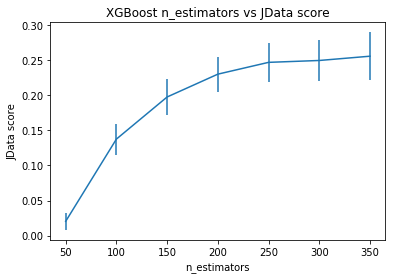

In [69]:
clf = XGBClassifier(nthread=-1)
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)

grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=kfold, refit=refit, return_train_score=True)
%time grid_result = grid_search.fit(res_X, res_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_custom"]
stds = grid_result.cv_results_["std_test_custom"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs JData score")
pyplot.xlabel('n_estimators')
pyplot.ylabel('JData score')

In [70]:
# pd.DataFrame(grid_result.cv_results_).to_csv('../reports/search_n_estimators_all_merged_1.0_rus_0.01.csv', index=False)
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,mean_test_custom,std_test_custom,rank_test_custom,split0_train_custom,split1_train_custom,split2_train_custom,split3_train_custom,split4_train_custom,mean_train_custom,std_train_custom
0,10.345830,0.616168,0.130151,0.000377,50,{'n_estimators': 50},0.008159,0.031499,0.016072,0.008258,0.038320,0.020462,0.012331,7,0.014692,0.031307,0.031237,0.029371,0.045792,0.030480,0.009861
1,19.759336,0.689792,0.141277,0.003841,100,{'n_estimators': 100},0.109260,0.124292,0.126968,0.165320,0.161481,0.137464,0.022054,6,0.193320,0.207606,0.207831,0.177683,0.209050,0.199098,0.012163
2,29.542123,0.548024,0.149840,0.004706,150,{'n_estimators': 150},0.164845,0.177534,0.200740,0.240349,0.203490,0.197392,0.025874,5,0.279885,0.290527,0.298199,0.284160,0.298968,0.290348,0.007533
3,38.804685,0.622995,0.175548,0.020653,200,{'n_estimators': 200},0.189923,0.227379,0.221688,0.264628,0.245696,0.229863,0.025010,4,0.324053,0.336877,0.337817,0.331184,0.328272,0.331640,0.005190
4,48.499597,0.507014,0.167636,0.006442,250,{'n_estimators': 250},0.201193,0.233741,0.251662,0.283567,0.263073,0.246647,0.027895,3,0.355731,0.371286,0.367679,0.367562,0.359825,0.364416,0.005732
5,58.137169,0.390188,0.173975,0.005490,300,{'n_estimators': 300},0.199170,0.242964,0.254535,0.288854,0.261101,0.249325,0.029272,2,0.377716,0.399705,0.392300,0.383580,0.376119,0.385884,0.008939
6,67.842373,0.360425,0.188648,0.006309,350,{'n_estimators': 350},0.197200,0.255062,0.251675,0.301059,0.272027,0.255405,0.033949,1,0.402470,0.425674,0.415553,0.411816,0.399537,0.411010,0.009390


range(1, 11, 2)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 14.1min finished


CPU times: user 1h 55min 55s, sys: 15 s, total: 1h 56min 10s
Wall time: 15min 3s
Best: 0.234021 using {'max_depth': 7}
0.003243 (0.006485) with: {'max_depth': 1}
0.137464 (0.022054) with: {'max_depth': 3}
0.220086 (0.019913) with: {'max_depth': 5}
0.234021 (0.026701) with: {'max_depth': 7}
0.205460 (0.022881) with: {'max_depth': 9}


Text(0, 0.5, 'JData score')

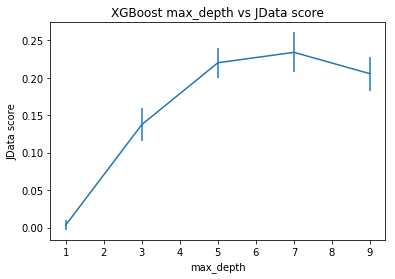

In [63]:
scoring, scorer = get_jdata_scoring(res_train)
scoring = {'custom': scoring["custom_index"]}
refit = 'custom'

clf = XGBClassifier(nthread=-1)
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)

grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=kfold, refit=refit, return_train_score=True)
%time grid_result = grid_search.fit(res_X, res_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_custom"]
stds = grid_result.cv_results_["std_test_custom"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
pyplot.errorbar(max_depth, means, yerr=stds)
pyplot.title("XGBoost max_depth vs JData score")
pyplot.xlabel('max_depth')
pyplot.ylabel('JData score')

In [66]:
# pd.DataFrame(grid_result.cv_results_).to_csv('../reports/search_max_depth_all_merged_1.0_rus_0.01.csv', index=False)
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,mean_test_custom,std_test_custom,rank_test_custom,split0_train_custom,split1_train_custom,split2_train_custom,split3_train_custom,split4_train_custom,mean_train_custom,std_train_custom
0,8.326099,0.457501,0.137296,0.014289,1,{'max_depth': 1},0.000000,0.000000,0.016213,0.000000,0.000000,0.003243,0.006485,5,0.002219,0.007518,0.008332,0.000000,0.003802,0.004374,0.003151
1,19.789830,0.624379,0.143762,0.007459,3,{'max_depth': 3},0.109260,0.124292,0.126968,0.165320,0.161481,0.137464,0.022054,4,0.193320,0.207606,0.207831,0.177683,0.209050,0.199098,0.012163
2,32.405513,0.654942,0.149051,0.004667,5,{'max_depth': 5},0.189768,0.221680,0.237682,0.244217,0.207084,0.220086,0.019913,2,0.413391,0.442361,0.424760,0.392333,0.411448,0.416859,0.016466
3,45.590803,0.841530,0.160639,0.006307,7,{'max_depth': 7},0.210482,0.213606,0.244934,0.281597,0.219485,0.234021,0.026701,1,0.659941,0.674216,0.677510,0.656636,0.651200,0.663901,0.010211
4,59.985545,0.539923,0.183415,0.023577,9,{'max_depth': 9},0.162218,0.212836,0.229071,0.217109,0.206066,0.205460,0.022881,3,0.859599,0.871682,0.865119,0.862630,0.861641,0.864134,0.004171


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 100.8min finished


CPU times: user 13h 21min 36s, sys: 47.7 s, total: 13h 22min 23s
Wall time: 1h 42min 15s
Best: 0.255405 using {'max_depth': 3, 'n_estimators': 350}
0.197392 (0.025874) with: {'max_depth': 3, 'n_estimators': 150}
0.229863 (0.025010) with: {'max_depth': 3, 'n_estimators': 200}
0.246647 (0.027895) with: {'max_depth': 3, 'n_estimators': 250}
0.249325 (0.029272) with: {'max_depth': 3, 'n_estimators': 300}
0.255405 (0.033949) with: {'max_depth': 3, 'n_estimators': 350}
0.234541 (0.017771) with: {'max_depth': 5, 'n_estimators': 150}
0.246971 (0.029070) with: {'max_depth': 5, 'n_estimators': 200}
0.250867 (0.023765) with: {'max_depth': 5, 'n_estimators': 250}
0.254450 (0.024770) with: {'max_depth': 5, 'n_estimators': 300}
0.251458 (0.022923) with: {'max_depth': 5, 'n_estimators': 350}
0.236743 (0.036602) with: {'max_depth': 7, 'n_estimators': 150}
0.233117 (0.030259) with: {'max_depth': 7, 'n_estimators': 200}
0.230338 (0.026532) with: {'max_depth': 7, 'n_estimators': 250}
0.229027 (0.028655) 

Text(0, 0.5, 'JData score')

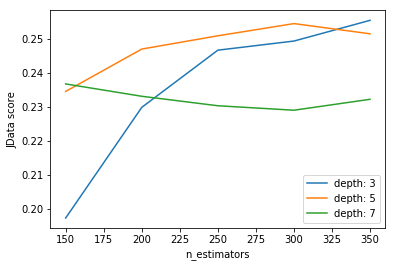

In [71]:
scoring, scorer = get_jdata_scoring(res_train)
scoring = {'custom': scoring["custom_index"]}
refit = 'custom'

clf = XGBClassifier(nthread=-1)
n_estimators = range(150, 400, 50)
max_depth = range(3, 9, 2)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)


grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=kfold, refit=refit, verbose=1, return_train_score=True)
%time grid_result = grid_search.fit(res_X, res_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_custom"]
stds = grid_result.cv_results_["std_test_custom"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('JData score')

In [16]:
# pd.DataFrame(grid_result.cv_results_).to_csv('../reports/search_estimators_and_max_depth_all_merged_1.0_rus_0.01.csv', index=False)
pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_custom')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,mean_test_custom,std_test_custom,rank_test_custom,split0_train_custom,split1_train_custom,split2_train_custom,split3_train_custom,split4_train_custom,mean_train_custom,std_train_custom
4,67.526084,0.451304,0.180826,0.007006,3,350,"{'max_depth': 3, 'n_estimators': 350}",0.197200,0.255062,0.251675,0.301059,0.272027,0.255405,0.033949,1,0.402470,0.425674,0.415553,0.411816,0.399537,0.411010,0.009390
8,94.745497,1.005545,0.212510,0.009376,5,300,"{'max_depth': 5, 'n_estimators': 300}",0.208894,0.254012,0.275801,0.277556,0.255986,0.254450,0.024770,2,0.658133,0.698347,0.695288,0.672171,0.666862,0.678160,0.015909
9,110.078499,0.645761,0.223414,0.007964,5,350,"{'max_depth': 5, 'n_estimators': 350}",0.208894,0.250019,0.276398,0.263204,0.258777,0.251458,0.022923,3,0.701318,0.743504,0.739977,0.717721,0.712907,0.723085,0.016177
7,79.283208,0.772501,0.188896,0.002988,5,250,"{'max_depth': 5, 'n_estimators': 250}",0.209890,0.248990,0.276849,0.272028,0.246579,0.250867,0.023765,4,0.615086,0.647915,0.649528,0.621947,0.617710,0.630437,0.015097
3,57.889527,0.425892,0.172371,0.004201,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.199170,0.242964,0.254535,0.288854,0.261101,0.249325,0.029272,5,0.377716,0.399705,0.392300,0.383580,0.376119,0.385884,0.008939
6,63.726466,0.309610,0.182458,0.006968,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.197957,0.240933,0.276849,0.276543,0.242574,0.246971,0.029070,6,0.563117,0.594658,0.588068,0.570993,0.554340,0.574235,0.015089
2,48.580759,0.506734,0.171784,0.005992,3,250,"{'max_depth': 3, 'n_estimators': 250}",0.201193,0.233741,0.251662,0.283567,0.263073,0.246647,0.027895,7,0.355731,0.371286,0.367679,0.367562,0.359825,0.364416,0.005732
10,67.872319,0.516165,0.182100,0.007241,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.180903,0.223141,0.244791,0.294331,0.240548,0.236743,0.036602,8,0.764091,0.783637,0.790205,0.756807,0.743332,0.767614,0.017239
5,48.159210,0.551299,0.164689,0.004345,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.205378,0.231583,0.241862,0.260332,0.233552,0.234541,0.017771,9,0.499536,0.520350,0.519202,0.503633,0.486984,0.505941,0.012563
11,90.079715,0.460578,0.200820,0.008876,7,200,"{'max_depth': 7, 'n_estimators': 200}",0.182879,0.229393,0.246795,0.276083,0.230437,0.233117,0.030259,10,0.848851,0.852149,0.859779,0.844411,0.835301,0.848098,0.008134


## traning whole dataset -> worse

In [ ]:
param = {'max_depth': 3, 'n_estimators': 350}
clf = XGBClassifier(nthread=-1, **param)

X, y = get_X_y(train)
%time clf.fit(X, y)

In [84]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [85]:
# use our best model to evalute result of the whole local data
scoring, scorer = get_jdata_scoring(train)
scores = scoring['custom_index'](clf, X, y, np.arange(X.shape[0]))
print(f'whole local result: {scores}')

whole local result: 0.04065112543626942


## use model trained by sampling dataset to submit -> not good enough

In [12]:
param = {'max_depth': 3, 'n_estimators': 350}
clf = XGBClassifier(nthread=-1, **param)
%time clf.fit(res_X, res_y)

scoring, scorer = get_jdata_scoring(train)
scores = scoring['custom_index'](clf, X, y, np.arange(X.shape[0]))
print(f'whole local result: {scores}')

CPU times: user 11min 41s, sys: 436 ms, total: 11min 41s
Wall time: 1min 31s
whole local result: 0.19167695092846476


In [13]:
score_df = score_whole_dataset(clf, online_train)

In [14]:
score_df

,test_correct_user_num,test_precision_1,test_recall_1,test_f11,test_correct_sku_num,test_precision_2,test_recall_2,test_f12,test_score
0,1253,0.127092,0.440732,0.144194,483,0.048991,0.169891,0.085496,0.108975


In [ ]:
# trytry place

In [17]:
# rank3
param = {'max_depth': 5, 'n_estimators': 350}
clf = XGBClassifier(nthread=-1, **param)
%time clf.fit(res_X, res_y)

scoring, scorer = get_jdata_scoring(train)
scores = scoring['custom_index'](clf, X, y, np.arange(X.shape[0]))
print(f'whole local result: {scores}')

CPU times: user 18min 42s, sys: 704 ms, total: 18min 43s
Wall time: 2min 25s
whole local result: 0.3716823503043135


In [18]:
score_df = score_whole_dataset(clf, online_train)
score_df

,test_correct_user_num,test_precision_1,test_recall_1,test_f11,test_correct_sku_num,test_precision_2,test_recall_2,test_f12,test_score
0,1221,0.123621,0.429476,0.14027,449,0.045459,0.157932,0.079376,0.103734


In [20]:
## 增加深度 local score 增加但是 online 分數沒有增加，代表 feature 無法提供足夠的資訊讓 model 預測？

In [ ]:
## overfitting?

In [ ]:
## ensemble to reduce overfitting

In [19]:
## sampling 3 sample datasets to ensemble results

In [22]:
import random

rslt = []
for i in range(3):
    rs = {}
    method = 'rus'
    ratio = 0.01
    random_state = random.randint(0, 10000)
    sampler_setting = {"name": method, "ratio": ratio, "random_state": random_state}
    print(sampler_setting)
    s = sampler(**sampler_setting)
    res_X, res_y, indices = s.fit_sample(X, y)
    
    rs['method'] = method
    rs['ratio'] = ratio
    rs['random_state'] = random_state
    rs['indices'] = indices
    
    param = {'max_depth': 3, 'n_estimators': 350}
    clf = XGBClassifier(nthread=-1, **param)
    %time clf.fit(res_X, res_y)
    
    rs['param'] = param
    rs['model'] = clf

    scoring, scorer = get_jdata_scoring(train)
    scores = scoring['custom_index'](clf, X, y, np.arange(X.shape[0]))
    print(f'whole local result: {scores}')
    
    rs['scoring'] = scoring
    rs['scorer'] = scorer
    rslt.append(rs)

{'name': 'rus', 'ratio': 0.01, 'random_state': 5206}
CPU times: user 11min 8s, sys: 528 ms, total: 11min 8s
Wall time: 1min 26s
whole local result: 0.1969698161802781
{'name': 'rus', 'ratio': 0.01, 'random_state': 2052}
CPU times: user 10min 58s, sys: 386 ms, total: 10min 59s
Wall time: 1min 25s
whole local result: 0.2001613891152157
{'name': 'rus', 'ratio': 0.01, 'random_state': 7899}
CPU times: user 11min 3s, sys: 364 ms, total: 11min 4s
Wall time: 1min 26s
whole local result: 0.19254721732271013


In [24]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('xgb1', rslt[0]['model']), ('xgb2', rslt[1]['model']), ('xgb3', rslt[2]['model'])], voting='soft')
%time eclf = eclf.fit(res_X, res_y)

CPU times: user 33min 11s, sys: 1.27 s, total: 33min 12s
Wall time: 4min 18s


In [25]:
score_whole_dataset(eclf, online_train)

,test_correct_user_num,test_precision_1,test_recall_1,test_f11,test_correct_sku_num,test_precision_2,test_recall_2,test_f12,test_score
0,1340,0.116088,0.471333,0.132765,536,0.046435,0.188533,0.08477,0.103968


In [ ]:
# TODO
# remove unseen sku?

# plot importance

In [29]:
feature_names = train.drop(columns=["user_id", "label"]).columns
feature_mapping = dict([('f{}'.format(i), feature_names[i]) for i in range(len(feature_names))])

In [30]:
from sklearn import preprocessing

def plot_importance(model, feature_mapping, n=30):

    # Get xgBoost importances
    importance_dict = {}
    for import_type in ['weight', 'gain', 'cover']:
        importance_dict['xgBoost-{}'.format(import_type)] = model.get_booster().get_score(importance_type=import_type)

    # MinMax scale all importances
    importance_df = pd.DataFrame(importance_dict).fillna(0)
    importance_df = pd.DataFrame(
        preprocessing.MinMaxScaler().fit_transform(importance_df),
        columns=importance_df.columns,
        index=importance_df.index
    )

    # replace index
    importance_df.index = importance_df.index.map(mapper=feature_mapping)

    # Create mean column
    importance_df['mean'] = importance_df.mean(axis=1)

    # Plot the feature importances
    importance_df.sort_values('mean').head(n).plot(kind='bar', figsize=(20, 10))

/home/makalon/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


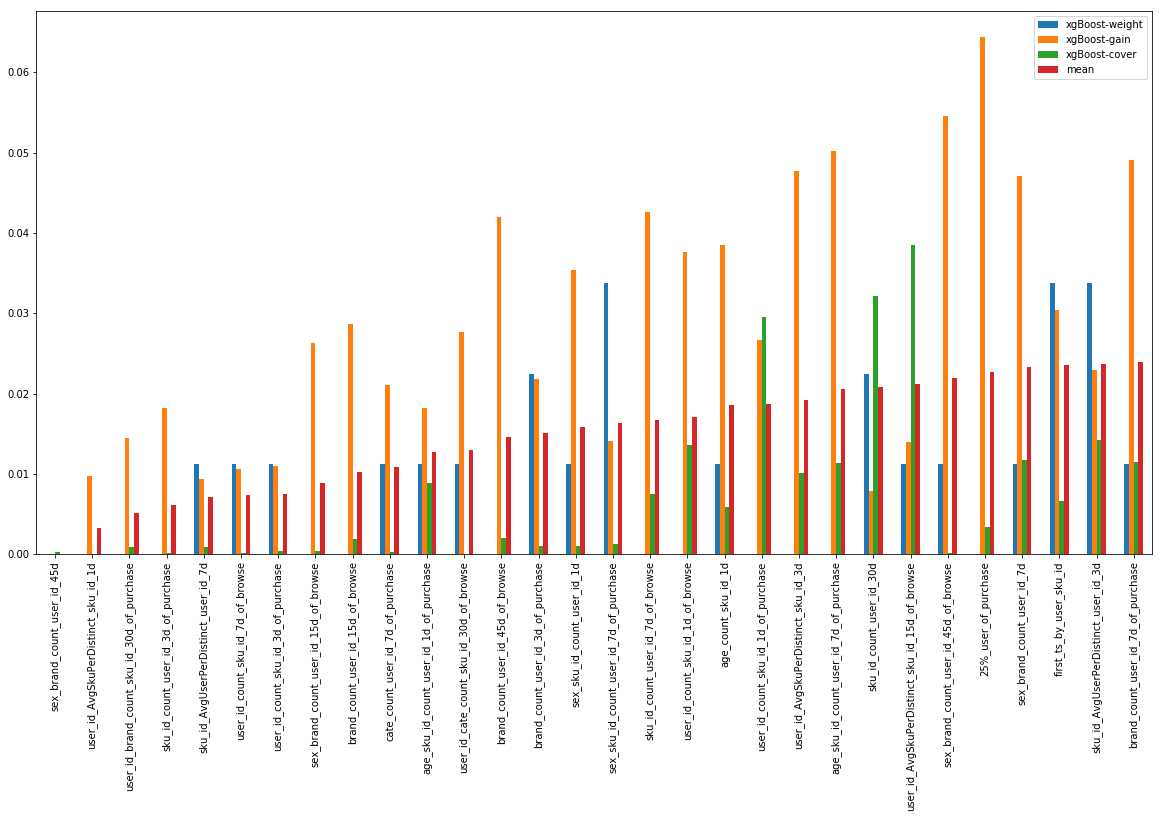

In [31]:
plot_importance(clf, feature_mapping)